In [1]:
# Misc Python Imports
import random
import numpy as np
import itertools

# Game Imports
from tetris.Tetris import Tetris, O

# Local Imports
import params
import model
import utils
import memory
import reward
import loss
import pickle


# Torch Imports & initialisation
import torch
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


if params.TENSORBOARD_LOGGING:
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter()
else:
    writer = None

In [2]:
# Game initialisation
env = Tetris(pieces=[O])
env.lockout_rate = 0
env.start_drop_rate = 1
env.reset()
num_states = len(env.actions) - 2  # Get rid of hard + soft drop for now...

# Get screen size so that we can initialize layers correctly based on shape
init_screen, _ = utils.get_screen(env.get_grid(), device)
_, _, screen_height, screen_width = init_screen.shape
# Attempt to load a net - if not make a new one
load_net_prefix = './models/statePredSquares2v'
load_net_number = 0
net_to_load = f'{load_net_prefix}{load_net_number}'
try:
    policy_net = torch.load(net_to_load)
    policy_net.eval()
    target_net = torch.load(net_to_load)
    target_net.eval()
    print(f'{net_to_load} loaded...')
except FileNotFoundError:
    policy_net = model.DQN(screen_height, screen_width, num_states).to(device)
    target_net = model.DQN(screen_height, screen_width, num_states).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    print(f'Fell back to creating a new net...')

# Set up optimizer and memory
optimizer = optim.Adam(policy_net.parameters(), lr=params.LEARNING_RATE)
try:
    model_memory = pickle.load(open('./models/latest_memory.pk', 'rb'))
    print('Latest memories loaded...')
except FileNotFoundError:
    model_memory = memory.ReplayMemory(params.MEMORY_SIZE)
    print('Fell back to making new memories...')

Fell back to creating a new net...
Latest memories loaded...


In [3]:
def select_action(state, eps_threshold, next_piece, force_log=False):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # # found, so we pick action with the larger expected reward.
            q_vals = policy_net.eval()(state, next_piece)[0]
            if force_log:
                sum_q = q_vals.abs().sum()
#                 utils.tblogger('Q0', q_vals[0, 0] / sum_q, writer)
#                 utils.tblogger('Q1', q_vals[0, 1] / sum_q, writer)
#                 utils.tblogger('Q2', q_vals[0, 2] / sum_q, writer)
#                 utils.tblogger('Q3', q_vals[0, 3] / sum_q, writer)
#                 utils.tblogger('Q4', q_vals[0, 4] / sum_q, writer)
            return q_vals.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_states)]], device=device, dtype=torch.long)



# Yes yes, I'm a terrible person - I'll clean this up later
steps_done = 0
episode_durations = []
lines_cleared = []
eps_values = []

In [4]:
def train(num_episodes=1000, human=False):
    global steps_done

    for i_episode in range(num_episodes):
        # Initialize the environment and state
        height, old_height, lines, old_lines = 0, 0, 0, 0
        env.reset()
        last_state, _ = utils.get_screen(env.get_grid(), device)
        state, next_piece = utils.get_screen(env.get_grid(), device)

        # if not human:
        state_array = [last_state] * params.MULTISTEP_PARAM
        reward_array = [0] * params.MULTISTEP_PARAM
        reward_sum = 0
        array_pos = 0
        next_array_pos = 1
        warmup = 0
        game_reward = 0
        game_reward_decayed = 0

        for t in itertools.count():
            steps_done += 1
            # Select and perform an action
            if human:
                eps = 0
            else:
                eps = utils.curr_eps(steps_done)
            action = select_action(state, eps, next_piece, i_episode % 100 == 0)
            state, _, done = env.step(action.item())
            piece_fell = reward.did_piece_fall(env)

            # Observe new state
            state, next_piece = utils.get_screen(state, device)

            if not human:
                state_array[array_pos] = state

                # Create reward
                height = reward.get_height(env)
                lines = env._total_lines_cleared
                reward_single = reward.create_reward(piece_fell, action, done, height, old_height, lines, old_lines)
                reward_sum = (params.MULISTEP_GAMMA * reward_sum) + reward_single - (params.MULISTEP_GAMMA ** params.MULTISTEP_PARAM) * reward_array[array_pos]
                reward_array[array_pos] = reward_single
                reward_sum = torch.tensor([reward_sum], device=device).type(torch.float)
                game_reward += reward_single
                game_reward_decayed = game_reward_decayed * params.GAMMA + reward_single

                # Store the transition in memory
                if warmup > params.MULTISTEP_PARAM:
                    model_memory.push(state_array[next_array_pos], action, state, reward_sum, next_piece)

                # Perform one step of the optimization (on the target network)
                if (warmup + 1) % params.TRAIN_RATE == 0:
                    loss.optimize_model(optimizer, model_memory, policy_net, target_net, writer)
                if done or t > 5000:
                    # 5000 here just to stop us playing forever...

                    # Tensorboard logging
                    utils.tblogger('Duration', t, writer)
                    utils.tblogger('Cleared Lines', lines, writer)
                    utils.tblogger('Epsilon', eps, writer)
                    utils.tblogger('Reward', game_reward, writer)
                    utils.tblogger('Decayed Reward', game_reward_decayed, writer)

                    # Normal logging
                    episode_durations.append(t + 1)
                    lines_cleared.append(lines)
                    eps_values.append(eps)
                    utils.plot_durations(episode_durations, lines_cleared, eps_values, save='latest.png')
                    break

            else:
                if done:
                    break

            # Set up params for next frame
            old_height = height
            old_lines = lines
            if not human:
                array_pos = (array_pos + 1) % params.MULTISTEP_PARAM
                next_array_pos = (next_array_pos + 1) % params.MULTISTEP_PARAM
                warmup += 1

        if not human:
            # Update the target network, copying all weights and biases in DQN
            if i_episode % params.TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

In [5]:
def watch_model(rounds=1000):
    with torch.no_grad():
        train(rounds, human=True)

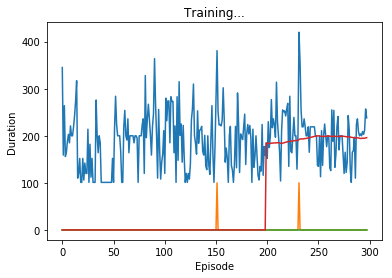

In [ ]:
# Train and save the model at intervals
idx = load_net_number
while True:
    train(10000)
    torch.save(policy_net, f'{load_net_prefix}{idx}')
    pickle.dump(model_memory, open('./models/latest_memory.pk', 'wb'))
    idx += 1

# from tetris.Tetris import watch_bot_tetris
# action_func = lambda e: policy_net.eval()(utils.get_screen(e.get_grid(), device)).max(1)[1].view(1, 1).squeeze().item()
# watch_bot_tetris(action_func, pieces=[O])

In [7]:
idx

16

In [8]:
torch.save(policy_net, f'{load_net_prefix}{idx}')